In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
from progressbar import progressbar as pbar
from rlxutils import subplots, copy_func
%matplotlib inline

# Our model

We observe $X_i$, which is the number of messages arrived at a certain location at day $i$ with $i \in \{0,...,n-1\}$, so that we have $n$ days.

We were usually receiving the messages following $\sim \text{Poisson}(2)$, but after a certain day the behaviour changed and we received more messages per day, following $\sim \text{Poisson}(4)$.


$$\begin{align*}
\tau &\in (0,1)\\
\text{for }  i &= 1\ldots N: \\
X_i &= \begin{cases} \text{Poisson}(2), & \tau > i/N \\ \text{Poisson}(4), & \text{otherwise}\end{cases}\\
\end{align*}$$

$$
\tau \sim \text{Uniform}[\text{low}=0,\text{high}=1] \text{   this is the prior}
$$


In [2]:
# globals
poisson_A = stats.poisson(2)
poisson_B = stats.poisson(4)

support = 0,1

# real (and unknown) parameter
real_tau = 0.8

In [3]:
class TModel:
        
    def __init__(self, tau):        
        assert tau>=0 and tau<=1        
        self.tau = tau
        
    def rvs(self, n):
        n1 = int(n*self.tau)
        n2 = n - n1
        
        r = list(poisson_A.rvs(n1)) + list(poisson_B.rvs(n2))
        return r

# our observations

In [4]:
x = TModel(tau=real_tau).rvs(30)

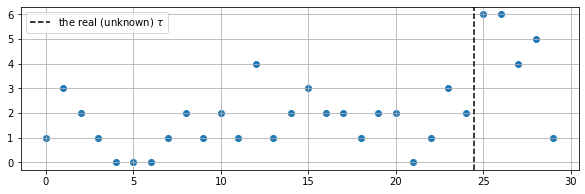

In [5]:
plt.figure(figsize=(10,3))
plt.scatter(range(len(x)), x)
plt.axvline(real_tau*len(x)+.5, ls="--", color="black", label=r"the real (unknown) $\tau$")
plt.grid(); plt.legend();

# probability functions

observe we are using log probabilities, to handle very very small probability values arising when multiplying probabilities of all data points.

The plots below show **both** probabilities and log probabilities for comparison.

Observe how we compute the normalization factor in `get_logposterior_fn` very naively with Montecarlo integration.

In [6]:
# loglikelihood on tau
def loglikelihood(tau):
    n = int(len(x)*tau)
    return np.sum(np.log(poisson_A.pmf(x[:n]))) + np.sum(np.log(poisson_B.pmf(x[n:])))    
    
# the posterior (using Bayes theorem)
def get_logposterior_fn(loglikelihood_fn, logprior_fn, support, integration_intervals=1000):
    assert len(support)==2

    # naive computation of the integral
    xr = np.linspace(*support, integration_intervals)
    Z = np.log(np.sum([np.exp(loglikelihood_fn(x) + logprior_fn(x)) for x in xr]) * (xr[1]-xr[0]))
    
    posterior_fn = lambda x: copy_func(loglikelihood_fn)(x) + copy_func(logprior_fn)(x) -  Z
    return posterior_fn

def plot_logprobs(logprior, logposterior):
    rtau = np.linspace(*support,100)

    for ax,i in subplots(4, usizex=5, n_cols=2):
        if i in [0,2]:
            p = logprior if i==0 else lambda x: np.exp(logprior(x))
            plt.plot(rtau, [p(tau) for tau in rtau])
            plt.grid();   
            plt.title(("log " if i==0 else "")+"prior probability")
        if i in [1,3]:
            p = logposterior if i==1 else lambda x: np.exp(logposterior(x))
            plt.plot(rtau, [p(tau) for tau in rtau])
            plt.axvline(real_tau, color="black")
            plt.title(("log " if i==1 else "")+"posterior probability")
            plt.grid();
    
        plt.xlabel(r"$\tau$")
    plt.tight_layout()

In [7]:
# a uniform prior on tau
logprior = lambda tau: np.log(stats.uniform(*support).pdf(tau))

In [8]:
logposterior = get_logposterior_fn(loglikelihood, logprior, support)

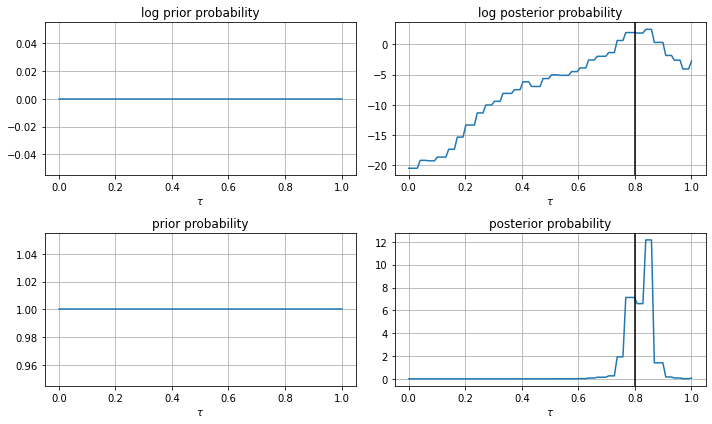

In [9]:
plot_logprobs(logprior, logposterior)

In [10]:
## check the integral of the posterior adds up to 1
## we do this for sanity, as numerical errors computing the 
## integral in bayes theorem might arise very easily
rtau = np.linspace(*support,1000)
np.sum([np.exp(logposterior(tau))/len(rtau) for tau in rtau])

0.9990000000000026

# a very extreme and wrong prior on tau


In [11]:
unnormalized_prior = lambda x: (1-x+.01)**20
Z = quad(unnormalized_prior, *support)[0]
logprior = lambda x: np.log(unnormalized_prior(x)/Z)

In [12]:
logposterior = get_logposterior_fn(loglikelihood, logprior, support)

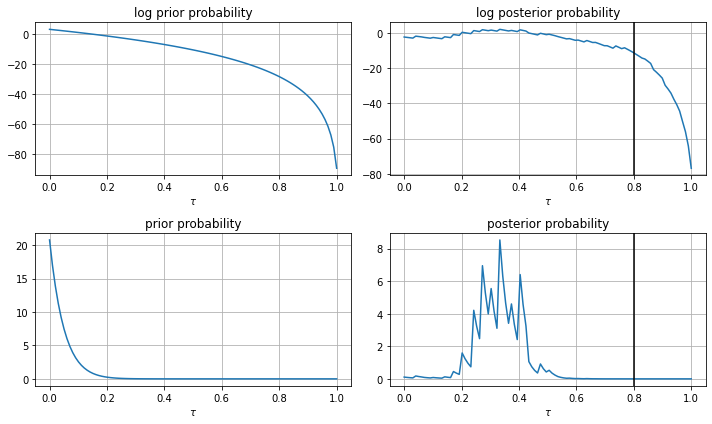

In [13]:
plot_logprobs(logprior, logposterior)

In [14]:
## check the integral of the posterior adds up to 1
rtau = np.linspace(*support,1000)
np.sum([np.exp(logposterior(tau))/len(rtau) for tau in rtau])

0.9989999999999977

# increased data overcomes very wrong priors

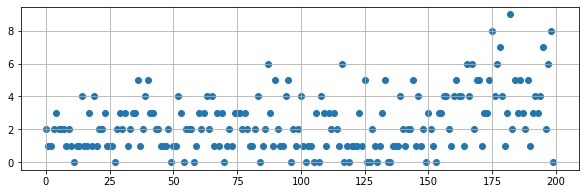

In [24]:
x = TModel(tau=real_tau).rvs(200)
plt.figure(figsize=(10,3))
plt.scatter(range(len(x)), x)
#plt.axvline(real_tau*len(x)+.5, ls="--", color="black")
plt.grid();

In [25]:
logposterior = get_logposterior_fn(loglikelihood, logprior, support)

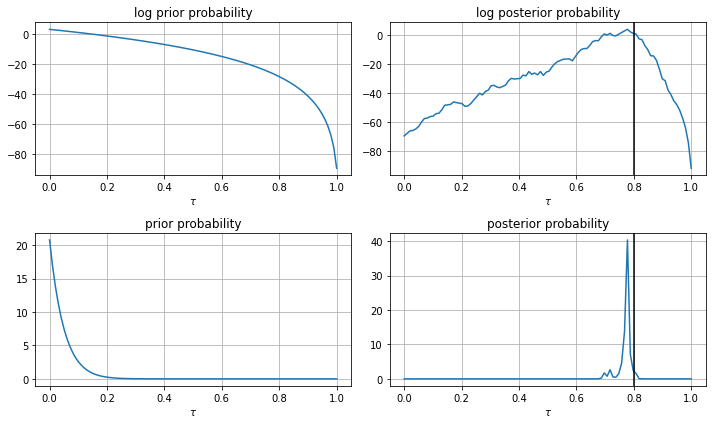

In [26]:
plot_logprobs(logprior, logposterior)

In [27]:
## check the integral of the posterior adds up to 1
rtau = np.linspace(*support,1000)
np.sum([np.exp(logposterior(tau))/len(rtau) for tau in rtau])

0.9990000000000223